In [1]:
import os
os.chdir('..')

In [2]:
import warnings 
import statistics

import numpy   as np 
import pandas  as pd

import seaborn as sns
from matplotlib import pyplot as plt
# sns.set()
from core.data import utils  as dataUtils

from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Loading data

In [91]:
allData = pd.read_csv('assets/covid_spread.csv', parse_dates=['Date'])
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


Preprocess the input dataframe. Fill empty states with their country names (this will make working with regions much easier).

In [92]:
def preprocess_data(df):
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

def get_population_data(df):
    new_df = pd.read_csv('assets/covid19countryinfo.csv', thousands=',')
    countries = new_df["country"].unique()
    pop = new_df[["pop", "country"]]
    df = df.rename(columns={"Province_State": "country"})
    newData = pd.merge(df, pop, on="country")
    return newData
    

In [93]:
allData = preprocess_data(allData)
allData = get_population_data(allData)
allData = allData.rename(columns={"country": "Province_State", "pop": "Population"})
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Population
0,Afghanistan,Afghanistan,2020-01-22,0.0,0.0,38928346.0
1,Afghanistan,Afghanistan,2020-01-23,0.0,0.0,38928346.0
2,Afghanistan,Afghanistan,2020-01-24,0.0,0.0,38928346.0
3,Afghanistan,Afghanistan,2020-01-25,0.0,0.0,38928346.0
4,Afghanistan,Afghanistan,2020-01-26,0.0,0.0,38928346.0


## Approach

### Comparing 2 countries

Two countries are compared by incrementally sliding the source country **S** over the cadidate country **C** and computing the error (difference) between them. If **C** is not as evolved as **S**, we do not make the comparison. 

In [234]:
def compare_sequence(source, candidate, errorFunc):
    minError = np.inf
    minIdx   = -1

    # only check the countries that can influence
    if len(candidate) == len(source):
        noWindows  = len(candidate) - len(source)
        windowSize = len(source)

        # sliding window over candidate country
        for i in range(0, noWindows):

            # compute loss
            error = errorFunc(source, candidate[i:i + windowSize])

            # save the min error and its location
            if error <= minError:
                minError = error
                minIdx   = i

            return minError, minIdx
    else:
        print(len(candidate), len(source))
    
    # return none if invalid 
    return None, None

### Getting all neighbours

We discard the entries (days) which are below a specified alignment threshold for each feature **$TA_f$** (have less than a specified number of cases), for every country (**S** included). Then, we take a candidate country, **$C_n$**. **$C_n$** must be more evolved than **S** (this means it reached **$T_a$** earlier). We start sliding **S** over **$C_n$**, beginning with the first day it reached the treshold, until **$C_n$** ends. For each such step, an error is computed.  The smallest error will be the error associated with **$C_n$**. We do this for all countries that are available in the dataset, taking one feature f, f in {confirmedCases, fatalities}, at a time. During training, the neighbours will be filtered by applying an error threshold **$T_{error}$**.

**Note:** in Pandas, sort_values is a very time expensive operation, this can be avoided if we are sure that the input data is sorted. I opted for doing this for safety reasons.  

In [200]:
 def get_nearest_sequence(df, state, alignThreshConf = 50, alignThreshDead = 10, errorFunc = mean_absolute_error):
    
    resDf = pd.DataFrame(columns=['Province_State', 'deathError', 'confirmedError', 'deathIdx', 'confirmedIdx'])
#     pop_threshold = df[df["Province_State"] == state]["Population"].values[0]
#     alignThreshConf = alignThreshConf + (pop_threshold / 100)
#     print(alignThreshConf)
    confDf = df[df['ConfirmedCases'] > alignThreshConf]
    deadDf = df[df['Fatalities'] > alignThreshDead]

    # get source region data
    regionDfConf = confDf[confDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    regionDfDead = deadDf[deadDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    
    regionConf = regionDfConf['ConfirmedCases'].values
    regionDead = regionDfDead['Fatalities'].values
    
    # check all possible candidates
    for neighbour in df['Province_State'].unique():

        # skip comparing with the same country
        if neighbour == state:
            continue

        # get country candidate
        confNeighDf = confDf[confDf['Province_State'] == neighbour].sort_values(by='Date', ascending = True)
        deadNeighDf = deadDf[deadDf['Province_State'] == neighbour].sort_values(by='Date',  ascending = True)

        neighConf = confNeighDf['ConfirmedCases'].values
        neighDead = deadNeighDf['Fatalities'].values

        # get error for confirmed and neighbour
        confErr, confIdx = compare_sequence(regionConf, neighConf, errorFunc)
        deadErr, deadIdx = compare_sequence(regionDead, neighDead, errorFunc)
        
        # the candidate will be ignored if it does not have enough data
        if confErr is None or deadErr is None:
            continue

        # append result
        res = {'Province_State':neighbour, 'deathError':deadErr, 'confirmedError':confErr,
                     'deathIdx':deadIdx, 'confirmedIdx':confIdx}

        resDf = resDf.append(res, ignore_index=True)

    return resDf

In [201]:
r = get_nearest_sequence(allData, 'France', 0, 0)
r.head() 

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,US,15229.447801,708233.258953,0,0


## Methods of evaluation

It is essential to choose a right metric such that the results are relevant. In essence, there should not be a huge difference between the losses, but it is safer to investigate at least some of the major error functions and see which one yields the best result.

### Metrics

#### 3.1.3 Mean absolute error

Arithmetic average of absolute errors.

$$MAE = \frac{1}{n}\sum_{t=1}^n\left| S_t-C_t\right|$$

#### 3.1.1 Mean average percentage error

 This yields the arithmetic average of the errors in percentage, relative to the source. This can be very easily thresholded and is easy to understand.

$$MAPE = \frac{1}{n}\sum_{t=1}^n  \left|\frac{S_t-C_t}{S_t}\right|$$

Below is a naive implementation.

In [9]:
def l1_norm_error(source, candidate):
    
    error = (abs(source - candidate))
    source[source == 0] = 1e-30       # add for numerical stability
    error = error/source              # normalize the error
    error = error.mean()
    
    return error

#### 3.1.2 Root mean squared log error

It implies a larger penalty for the underestimation of the result rather than the overestimating of it. This is the metric used in Kaggle competition for evaluation. 
$$ RMSLE = \sqrt{ \frac{1}{n} \sum_{t=1}^{n}  (\log{S_t} - \log{C_t})^2} $$

Below is a naive implementation.

In [212]:
def rmsle_error(source, candidate):
    candidate += 1e-30
    
    error  = np.log10((source+1)/(candidate+1)) # 1 is added for numerical stability 
    error  = error * error
    error  = error.mean()
    error  = np.sqrt(error) 
    
    return error

### Comparing metrics

Compare the losses: it is important to consider 2 types of countries:
- **top countries** - where the disease spreaded first and have the highest number of Confirmed Cases and Fatalities; this type of countries won't have many possible neighbours.
- **average countries** - where the disease has spread in a normal way, this countries will have lots of possible neighbours

In [53]:
def show_country_nn(data, sourceState, alignThreshConf, alignThreshDead, listErrorDf, errorNames):
    
    SHOW_FIRST = 5 # only show the first top neighbours
        
    # setup plot figures
    fig, axes = plt.subplots(len(listErrorDf), 2, 
                             figsize=(15, len(listErrorDf) * 3), 
                             gridspec_kw={'hspace': 0.3})
    # get rid of the annoying 
    axes = axes.flatten()

    fig.suptitle(sourceState.title(), fontsize=20)
    colors = sns.color_palette()[:SHOW_FIRST + 1]

    # only keep aligned data
    showDataConf = data[data['ConfirmedCases'] > alignThreshConf].copy()
    showDataDead = data[data['Fatalities'] > alignThreshDead].copy()
    showData     = [showDataConf, showDataDead]

    for i, (attr, err) in enumerate(zip(['ConfirmedCases', 'Fatalities'], 
                                        ['confirmedError', 'deathError'])):
        
        for j, (error, name) in enumerate(zip(listErrorDf, errorNames)):
            legend    = []
            axIdx     = j * 2 + i
            tempError = error.sort_values(by=err, ascending=True)
            
            # Exclude Hubei
            tempError = tempError[tempError["Province_State"] != "Hubei"]
                
            # only show available neighbours (if they are less than SHOW_FIRST)
            show = min(SHOW_FIRST, tempError.shape[0])
            
            for k in range(1, show + 1):

                # plot neighbours
                neighbour   = tempError['Province_State'].iloc[k - 1]
                tempShow    = showData[i][showData[i]['Province_State'] == neighbour][attr]
                xAxisValues = [z for z in range(tempShow.shape[0])]
                
                if len(xAxisValues) > 0:
                    legend.append(neighbour)

                sns.lineplot(x=xAxisValues, y=tempShow, color=colors[k], 
                             ax=axes[axIdx], linewidth=4.5)

            # plot source country
            tempShow    = showData[i][showData[i]['Province_State'] == sourceState][attr]
            xAxisValues = [z for z in range(tempShow.shape[0])]
            sns.lineplot(x=xAxisValues, y=tempShow, color=colors[0], 
                         ax=axes[axIdx], linewidth=4.5)

            # final touches to figure
            axes[axIdx].legend(legend + [sourceState])
            axes[axIdx].set_title(name.title() + ' error')
            axes[axIdx].grid(True)
            axes[axIdx].box = True
    return axes

This will show individual results for a country.

In [221]:
def test_metrics(trainData, sourceCountry, alignThreshConf, alignThreshDead, rmsle_errors=True):
    if rmsle_errors:
        errors = [rmsle_error]
        errorNames = ['RMSLE']
    else:
        errorNames = ['MAPE','MSE', 'RMSLE']
        errors     = [l1_norm_error, mean_absolute_error, rmsle_error]
    
    # compute error df for each metric
    results    = []
    for error in errors:
        r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
        results.append(r)
        display(r.sort_values("confirmedError"))
        
        
    # diplay for both fatalities and confirmed cases 
    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, results, errorNames)

#### Evolved country

An evolved country is a country having a high number of confirmed cases and fatalities.For this reason, such a country will not have many candidate countries with which they can be compared. Examples of evolved countries could be considered Italy or Spain.

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx


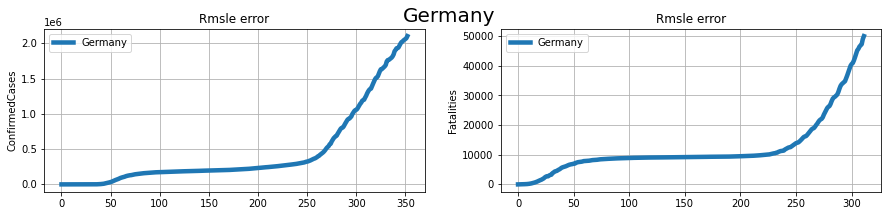

In [233]:
test_metrics(allData, 'Germany', 10, 10, rmsle_errors=True)

In this edge cases, the algorithm does not produce relevant results, hence there are not many countries that resemble the same growth. The algorithm was set to display the first 3 neighbours, but hence there aren't that many, only the possible ones are shown.

#### Normal spread country

To precisly choose a strong representant for this category, it would be ideal to iterate over all countries, compute the average number of possible neighbours and then choose a country which comes close to that number. 

The threshold for each category is chosen such that the begining plateau of the spreading is ignored (that period that has 1 confirmed case or so). A large threshold means using more recent data, and this is relevant for the prediction on short term, but it could also lead to irellevant results.

286 321
260 304
280 321
190 304
298 321
293 304
291 321
0 304
0 321
0 304
301 321
282 304
296 321
238 304
314 321
297 304
292 321
225 304
175 321
106 304
297 321
196 304
284 321
276 304
18 321
0 304
291 321
262 304
314 321
303 304
155 321
63 304
219 321
0 304
29 321
0 304
277 321
259 304
294 321
257 304
308 321
299 304
0 321
0 304
292 321
251 304
282 321
5 304
231 321
72 304
0 321
0 304
293 321
260 304
338 321
0 304
243 321
0 304
249 321
67 304
306 321
280 304
300 321
284 304
239 321
34 304
266 321
223 304
288 321
179 304
285 321
174 304
300 321
240 304
287 321
137 304
288 321
29 304
308 321
287 304
945 321
885 304
280 321
0 304
0 321
0 304
300 321
288 304
306 321
294 304
300 321
288 304
262 321
213 304
253 321
0 304
66 321
0 304
301 321
55 304
220 321
129 304
242 321
206 304
0 321
0 304
306 321
275 304
3210 321
3110 304
259 321
0 304
170 321
131 304
268 321
100 304
284 321
209 304
306 321
282 304
0 321
0 304
269 321
236 304
278 321
0 304
259 321
0 304
169 321
103 304
248 321
206 304
0

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx


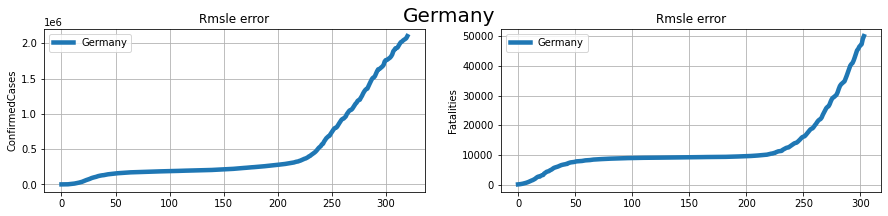

In [235]:
test_metrics(allData, 'Germany', 500, 100)

## 4. Results

Below are the graphs for the results obtained for confirmed cases (left) and
fatalities (right). The thresholds applied are 500 and 40 respectively.
The data that was used was last updated on ```26.01.2021``` .

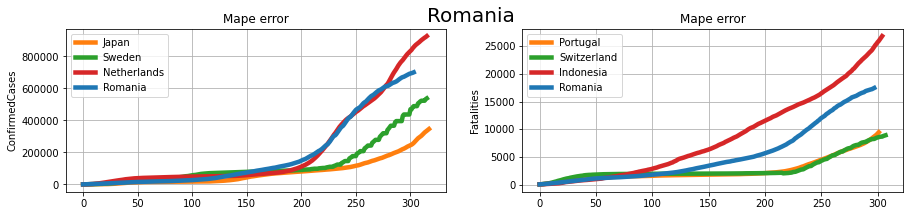

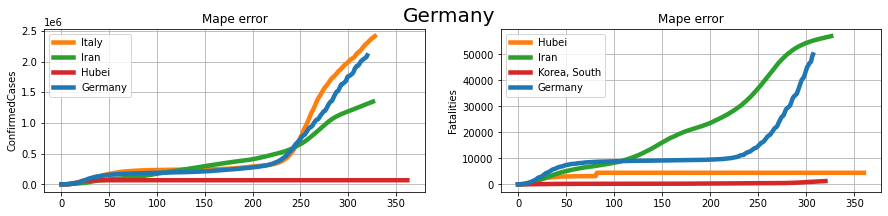

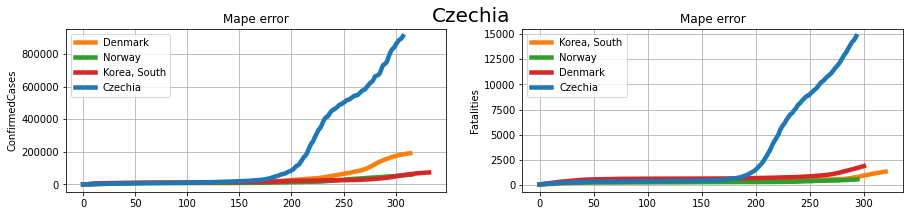

In [15]:
for country in ['Romania', 'Germany', 'Czechia']:
    r = get_nearest_sequence(allData, country, 500, 40, l1_norm_error)
    show_country_nn(allData, country, 500, 40, [r], ['MAPE'])

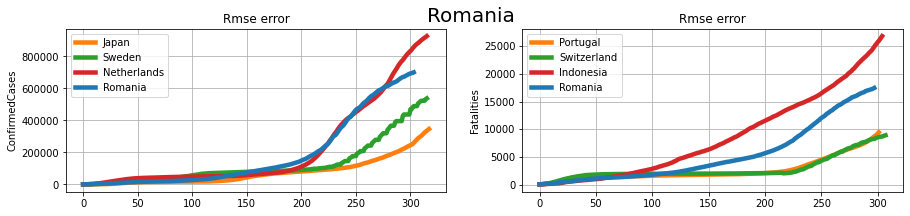

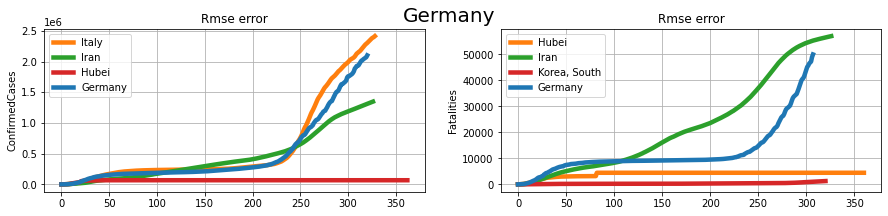

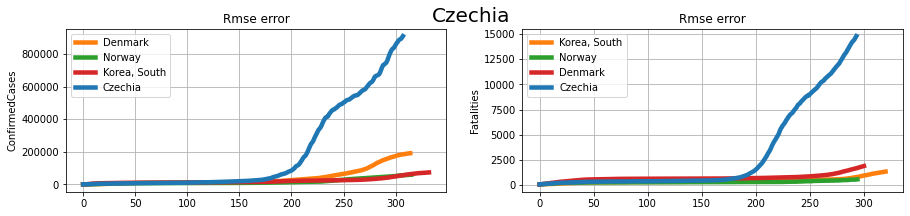

In [16]:
for country in ['Romania', 'Germany', 'Czechia']:
    r = get_nearest_sequence(allData, country, 500, 40, l1_norm_error)
    show_country_nn(allData, country, 500, 40, [r], ['RMSE'])